In [52]:
# Imports
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet152
from sklearn.metrics import confusion_matrix

In [2]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [48]:
#data
size = 124
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

# Load training and validation sets
train = image_dataset_from_directory('animal_data', labels='inferred', label_mode='int', subset='training', 
                                      validation_split=0.1, image_size=[size, size], interpolation='nearest', 
                                      batch_size=64, shuffle=True, seed=0)
valid = image_dataset_from_directory('animal_data', labels='inferred', label_mode='int', subset='validation', 
                                     validation_split=0.1, image_size=[size, size], interpolation='nearest', 
                                     batch_size=64, shuffle=True, seed=0)
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = (train.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))
valid = (valid.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE))

Found 1944 files belonging to 15 classes.
Using 1750 files for training.
Found 1944 files belonging to 15 classes.
Using 194 files for validation.


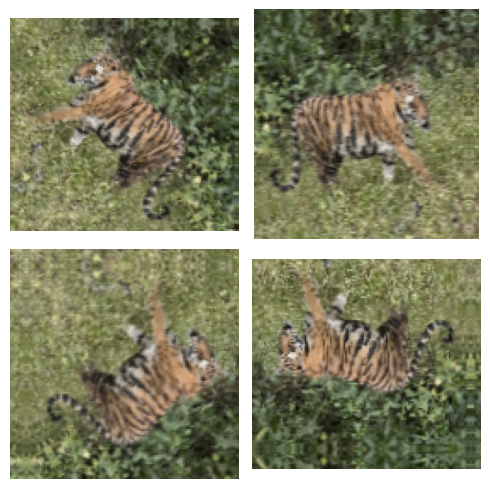

In [4]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    #preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
    preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    preprocessing.RandomWidth(factor=0.15), # horizontal stretch
    preprocessing.RandomRotation(factor=0.20),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)])

ex = next(iter(train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(5,5))
for i in range(4):
    image = augment(ex, training=True)
    plt.subplot(2, 2, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

In [14]:
def fitting(model, loss, metrics, optimiser = 'adam', ep = 25):
    
    model.compile(optimiser, loss = loss, metrics = metrics)
    history = model.fit(train, validation_data = valid, epochs = ep)
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, [metrics[0], 'val_' + metrics[0]]].plot();

In [15]:
#1st model
model_one = keras.Sequential([
    layers.InputLayer(input_shape=[size, size, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=1),
    preprocessing.RandomFlip(mode = 'horizontal'),
    preprocessing.RandomFlip(mode = 'vertical'),
    preprocessing.RandomRotation(factor = 0.10),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(15, activation='sigmoid')])

Epoch 1/25
28/28 [==============================] - 38s 1s/step - loss: 2.7252 - categorical_accuracy: 0.0651 - val_loss: 2.7091 - val_categorical_accuracy: 0.0464
Epoch 2/25
28/28 [==============================] - 43s 2s/step - loss: 2.7244 - categorical_accuracy: 0.0703 - val_loss: 2.7095 - val_categorical_accuracy: 0.0464
Epoch 3/25
28/28 [==============================] - 40s 1s/step - loss: 3.0516 - categorical_accuracy: 0.0771 - val_loss: 3.1332 - val_categorical_accuracy: 0.0619
Epoch 4/25
28/28 [==============================] - 42s 2s/step - loss: 5.0218 - categorical_accuracy: 0.0726 - val_loss: 2.7110 - val_categorical_accuracy: 0.0464
Epoch 5/25
28/28 [==============================] - 40s 1s/step - loss: 2.7072 - categorical_accuracy: 0.0731 - val_loss: 2.7115 - val_categorical_accuracy: 0.0464
Epoch 6/25
28/28 [==============================] - 41s 1s/step - loss: 2.7072 - categorical_accuracy: 0.0731 - val_loss: 2.7118 - val_categorical_accuracy: 0.0464
Epoch 7/25
28/28

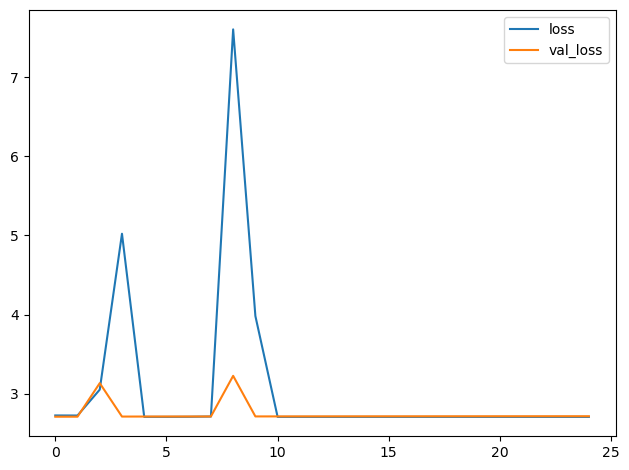

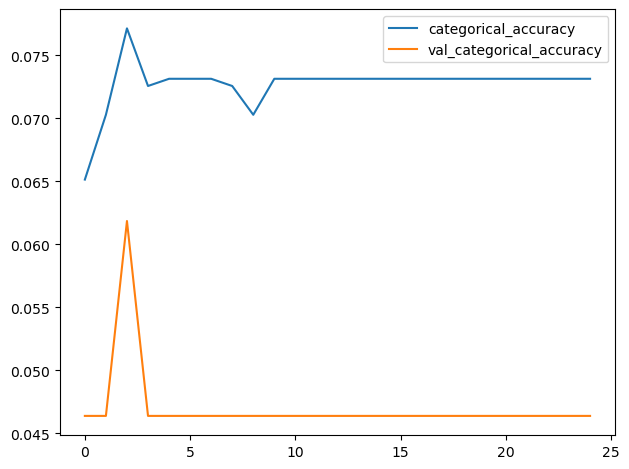

In [16]:
fitting(model_one, 'categorical_crossentropy', ['categorical_accuracy'])

In [17]:
#2nd model
model_two = keras.Sequential([
    layers.InputLayer(input_shape=[size, size, 3]),
    
    # Data Augmentation
    preprocessing.RandomContrast(factor=1),
    preprocessing.RandomFlip(mode = 'horizontal'),
    preprocessing.RandomFlip(mode = 'vertical'),
    preprocessing.RandomRotation(factor = 0.50),
    preprocessing.RandomRotation(factor=0.20),

    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(15, activation='sigmoid')])

Epoch 1/25
28/28 [==============================] - 43s 1s/step - loss: 2.7263 - accuracy: 0.0634 - val_loss: 2.7082 - val_accuracy: 0.0773
Epoch 2/25
28/28 [==============================] - 41s 1s/step - loss: 2.7128 - accuracy: 0.0737 - val_loss: 2.7180 - val_accuracy: 0.0464
Epoch 3/25
28/28 [==============================] - 40s 1s/step - loss: 2.7726 - accuracy: 0.0714 - val_loss: 2.7090 - val_accuracy: 0.0464
Epoch 4/25
28/28 [==============================] - 41s 1s/step - loss: 2.7456 - accuracy: 0.0703 - val_loss: 2.6967 - val_accuracy: 0.0515
Epoch 5/25
28/28 [==============================] - 40s 1s/step - loss: 6.5359 - accuracy: 0.0743 - val_loss: 22.1745 - val_accuracy: 0.0670
Epoch 6/25
28/28 [==============================] - 42s 1s/step - loss: 10.9552 - accuracy: 0.0771 - val_loss: 2.7094 - val_accuracy: 0.0722
Epoch 7/25
28/28 [==============================] - 40s 1s/step - loss: 2.9235 - accuracy: 0.0651 - val_loss: 2.7096 - val_accuracy: 0.0722
Epoch 8/25
28/28 [

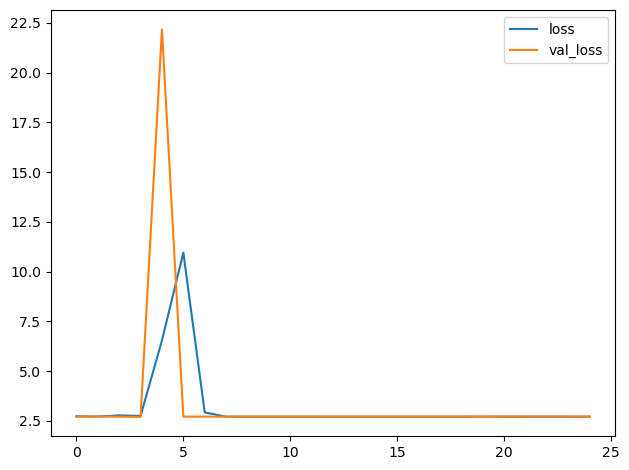

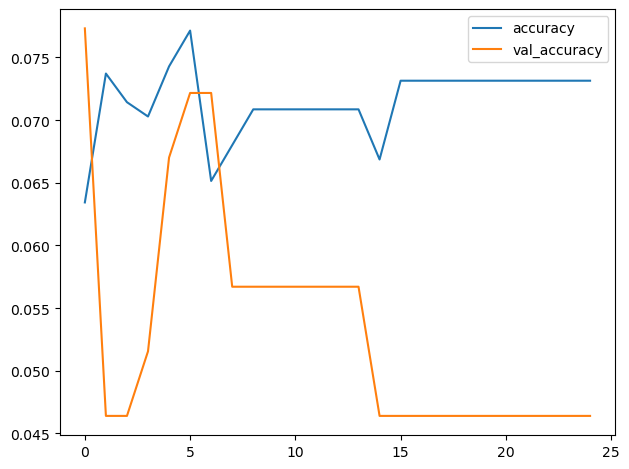

In [18]:
fitting(model_two, 'categorical_crossentropy', ['accuracy'])

In [19]:
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(size,size,3))
vgg.trainable=False

In [20]:
model_three = keras.Sequential([vgg, layers.Flatten(), 
                                layers.Dense(128, activation='relu'), layers.Dense(15, activation='softmax')])

Epoch 1/25
28/28 [==============================] - 32s 1s/step - loss: 2.0663 - accuracy: 0.3663 - val_loss: 1.4781 - val_accuracy: 0.5464
Epoch 2/25
28/28 [==============================] - 32s 1s/step - loss: 1.1272 - accuracy: 0.6577 - val_loss: 1.1844 - val_accuracy: 0.6289
Epoch 3/25
28/28 [==============================] - 32s 1s/step - loss: 0.8550 - accuracy: 0.7566 - val_loss: 1.0554 - val_accuracy: 0.6701
Epoch 4/25
28/28 [==============================] - 31s 1s/step - loss: 0.7148 - accuracy: 0.8126 - val_loss: 0.9562 - val_accuracy: 0.6907
Epoch 5/25
28/28 [==============================] - 32s 1s/step - loss: 0.6322 - accuracy: 0.8354 - val_loss: 0.8966 - val_accuracy: 0.6856
Epoch 6/25
28/28 [==============================] - 31s 1s/step - loss: 0.5754 - accuracy: 0.8457 - val_loss: 0.8352 - val_accuracy: 0.7268
Epoch 7/25
28/28 [==============================] - 31s 1s/step - loss: 0.5217 - accuracy: 0.8600 - val_loss: 0.8167 - val_accuracy: 0.7268
Epoch 8/25
28/28 [==

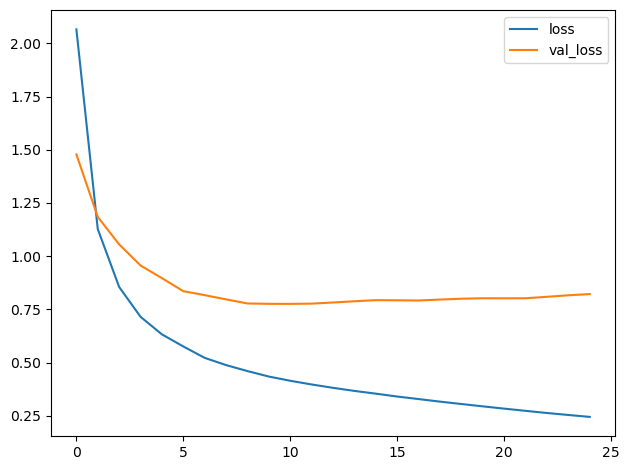

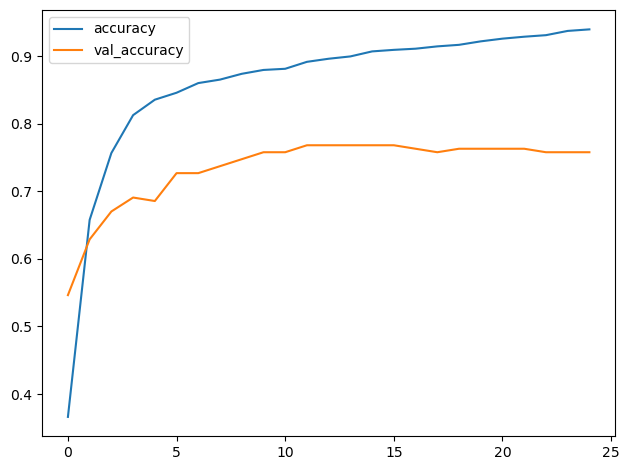

In [21]:
fitting(model_three, 'categorical_crossentropy', ['accuracy'])

In [24]:
res152 = ResNet152(include_top=False, weights='imagenet', input_shape=(size,size,3))
res152.trainable=False

In [25]:
res50 = ResNet50(include_top=False, weights='imagenet', input_shape=(size,size,3))
res50.trainable=False

94765736/94765736 [==============================] - 6s 0us/step


In [27]:
model_res152 = keras.Sequential([res152, layers.Flatten(), 
                                layers.Dense(128, activation='relu'), layers.Dense(15, activation='softmax')])

In [28]:
model_res50 = keras.Sequential([res50, layers.Flatten(), 
                                layers.Dense(128, activation='relu'), layers.Dense(15, activation='softmax')])

Epoch 1/25
28/28 [==============================] - 54s 2s/step - loss: 1.7712 - accuracy: 0.4446 - val_loss: 2.0138 - val_accuracy: 0.3196
Epoch 2/25
28/28 [==============================] - 50s 2s/step - loss: 1.7061 - accuracy: 0.4571 - val_loss: 2.0232 - val_accuracy: 0.3247
Epoch 3/25
28/28 [==============================] - 49s 2s/step - loss: 1.6812 - accuracy: 0.4714 - val_loss: 1.9926 - val_accuracy: 0.3247
Epoch 4/25
28/28 [==============================] - 47s 2s/step - loss: 1.6616 - accuracy: 0.4789 - val_loss: 1.9900 - val_accuracy: 0.3351
Epoch 5/25
28/28 [==============================] - 46s 2s/step - loss: 1.6426 - accuracy: 0.4857 - val_loss: 1.9925 - val_accuracy: 0.3196
Epoch 6/25
28/28 [==============================] - 47s 2s/step - loss: 1.6230 - accuracy: 0.4914 - val_loss: 1.9773 - val_accuracy: 0.3247
Epoch 7/25
28/28 [==============================] - 47s 2s/step - loss: 1.6060 - accuracy: 0.5046 - val_loss: 1.9772 - val_accuracy: 0.3351
Epoch 8/25
28/28 [==

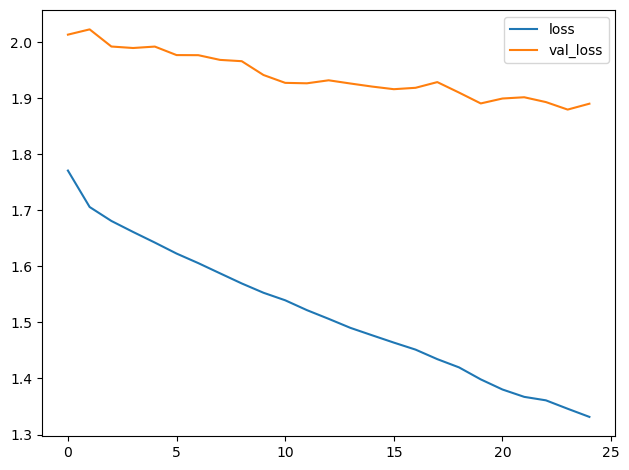

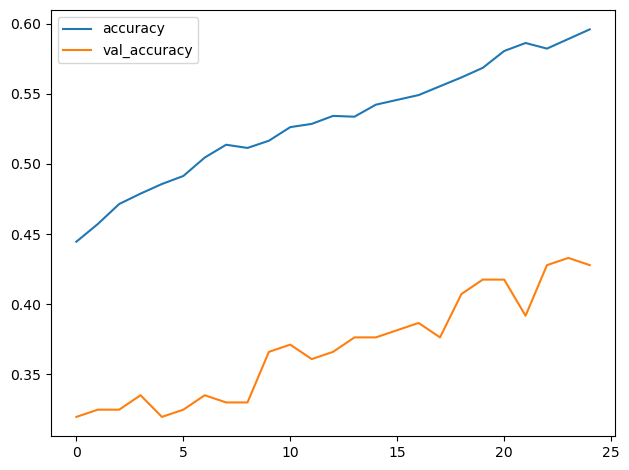

In [49]:
fitting(model_res152, 'sparse_categorical_crossentropy', ['accuracy'])

Epoch 1/25
28/28 [==============================] - 22s 683ms/step - loss: 2.8780 - accuracy: 0.0909 - val_loss: 2.6689 - val_accuracy: 0.1289
Epoch 2/25
28/28 [==============================] - 18s 659ms/step - loss: 2.6656 - accuracy: 0.1246 - val_loss: 2.6418 - val_accuracy: 0.1031
Epoch 3/25
28/28 [==============================] - 18s 663ms/step - loss: 2.6260 - accuracy: 0.1303 - val_loss: 2.6041 - val_accuracy: 0.1134
Epoch 4/25
28/28 [==============================] - 18s 662ms/step - loss: 2.5922 - accuracy: 0.1537 - val_loss: 2.5674 - val_accuracy: 0.1392
Epoch 5/25
28/28 [==============================] - 18s 662ms/step - loss: 2.5427 - accuracy: 0.1663 - val_loss: 2.5346 - val_accuracy: 0.1495
Epoch 6/25
28/28 [==============================] - 19s 666ms/step - loss: 2.5041 - accuracy: 0.1806 - val_loss: 2.5020 - val_accuracy: 0.1598
Epoch 7/25
28/28 [==============================] - 18s 658ms/step - loss: 2.4658 - accuracy: 0.1966 - val_loss: 2.4647 - val_accuracy: 0.1546

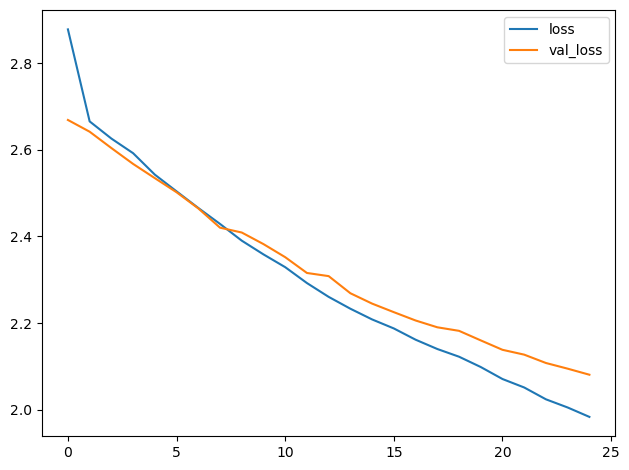

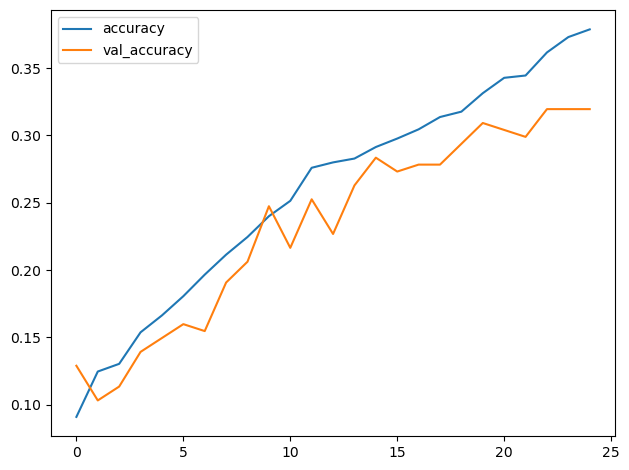

In [30]:
fitting(model_res50, 'sparse_categorical_crossentropy', ['accuracy'])

4/4 [==============================] - 5s 1s/step


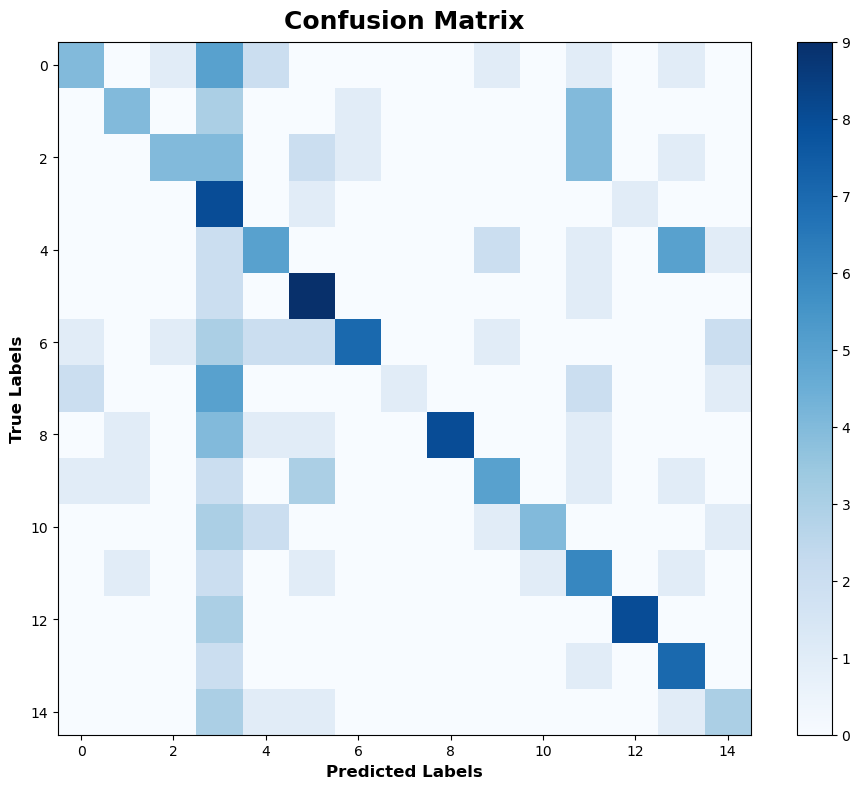

In [51]:
actual = np.concatenate([y for x, y in valid], axis=0)
pred = np.argmax(model_res152.predict(valid), axis=-1)
# Compute the confusion matrix
cm = confusion_matrix(actual, pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [58]:
test_im = cv2.imread("Cat\Cat_1.jpeg")
d = cv2.imread(test_im)
cv2.imshow(d)

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
